### Install necessary libraries

In [2]:
!pip install tensorflow==2.17.0 scikeras==0.13.0 keras==3.2.0

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os

# Disable oneDNN optimizations to avoid potential minor numerical differences caused by floating-point round-off errors.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#### Create parent folder for custom model training and child folders to store data

In [5]:
import os
import shutil
import random
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [6]:
import shutil
shutil.unpack_archive("Images.zip")

In [7]:
# Load labels and update image IDs
labels_df = pd.read_csv('labels.csv', sep=',', header=None)
labels_df.columns = ['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max']
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")
labels_df = labels_df.iloc[:1000]  # Limit to first 1000 entries
print('labels df loaded')
display(labels_df)

labels df loaded


image_id              class  x_min  y_min  x_max  y_max
0    00000000       pickup_truck    213     34    255     50
1    00000000                car    194     78    273    122
2    00000000                car    155     27    183     35
3    00000000  articulated_truck     43     25    109     55
4    00000000                car    106     32    124     45
..        ...                ...    ...    ...    ...    ...
995  00000306  motorized_vehicle     36     44     55     56
996  00000306                car    110     93    208    140
997  00000306  articulated_truck     55     19    111     37
998  00000307                car      2    233     17    283
999  00000307           work_van     75     46    115     73

[1000 rows x 6 columns]

In [8]:
# List to store image information (file path and shape)
images_dir = 'Images/'
image_data = []

# Iterate through all .jpg files in the directory
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(images_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Append the image path and shape to the list
            image_data.append([filename, img.shape])
        else:
            print(f"Error loading image: {img_path}")

# Create a DataFrame from the collected image data
image_df = pd.DataFrame(image_data, columns=['image_id', 'shape'])

# Get unique shapes and count occurrences
shape_counts = image_df['shape'].value_counts()

# Print the unique shapes and their counts
for shape, count in shape_counts.items():
    print(f"Shape: {shape}, Count: {count}")


Shape: (480, 720, 3), Count: 4462
Shape: (228, 342, 3), Count: 1164


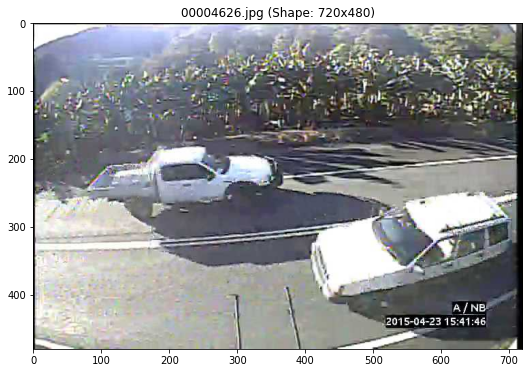

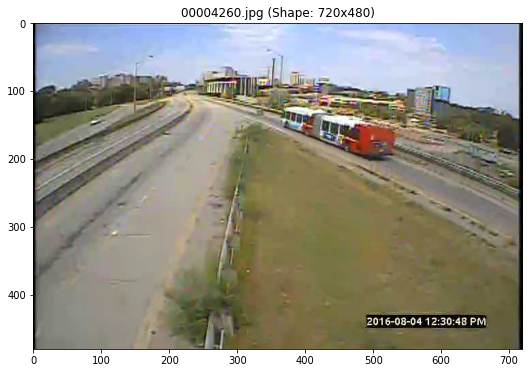

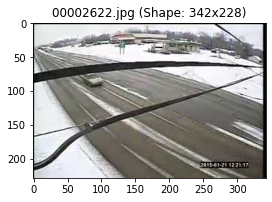

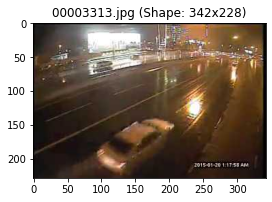

In [9]:
# Open N random images from each unique shape and display them true to size using matplotlib
dpi = 80  # Set DPI for the display
N = 2
for shape in shape_counts.index:
    # Get all images with this shape
    images_with_shape = image_df[image_df['shape'] == shape]['image_id']
    
    # Pick N random images (or fewer if less than N)
    sample_images = random.sample(list(images_with_shape), min(N, len(images_with_shape)))
    
    # Display the sampled images
    for img_file in sample_images:
        img_path = os.path.join(images_dir, img_file)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        # Get image dimensions
        height, width, _ = img.shape
        
        # Calculate figure size in inches to display true size
        figsize = (width / dpi, height / dpi)
        
        # Display image
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(img)
        ax.set_title(f"{img_file} (Shape: {width}x{height})")
        plt.show()


### Prepare the dataset for model training

In [10]:
def resize_and_pad_image_with_bbox(img, bbox, target_size=(320, 480)):
    original_size = img.shape[:2]
    aspect_ratio = original_size[1] / original_size[0]
    target_ratio = target_size[1] / target_size[0]

    # Resize image
    if aspect_ratio > target_ratio:
        new_width = target_size[1]
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = target_size[0]
        new_width = int(new_height * aspect_ratio)
    resized_img = cv2.resize(img, (new_width, new_height))

    # Scaling factors
    scale_x = new_width / original_size[1]
    scale_y = new_height / original_size[0]
    bbox = [bbox[0] * scale_x, bbox[1] * scale_y, bbox[2] * scale_x, bbox[3] * scale_y]

    # Padding to make image square
    delta_w = target_size[1] - new_width
    delta_h = target_size[0] - new_height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    new_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Adjust bounding box based on padding
    bbox = [bbox[0] + left, bbox[1] + top, bbox[2] + left, bbox[3] + top]
    return new_img, bbox

#### Image and bounding box resizing to make them consistent and retain same aspect ratio

The process below ensures consistent image sizes for machine learning models, crucial for efficient batching and accurate training. Resizing and padding maintain aspect ratios to avoid distortion, while verifying image loads ensures the dataset is complete and functional. Tracking unique shapes before and after resizing provides insights into dataset variability and preprocessing effectiveness.

In [11]:
images, classes, bounding_boxes = [], [], []
unique_shapes_before_resizing = set()


# Load and resize the corresponding images
images = []
for index, row in labels_df.iterrows():
    img_path = os.path.join(images_dir, f"{row['image_id']}.jpg")
    img = cv2.imread(img_path)
    if img is not None:
        bbox = [row['x_min'], row['y_min'], row['x_max'], row['y_max']]
        img, bbox = resize_and_pad_image_with_bbox(img, bbox, target_size=(320, 480))
        images.append(img)
        classes.append(row['class'])
        bounding_boxes.append(bbox)
    else:
        print(f"Error loading image: {img_path}")

# Convert lists to arrays and verify they have content
images = np.array(images)
classes = np.array(classes)
bounding_boxes = np.array(bounding_boxes)

if images.size == 0 or classes.size == 0:
    raise ValueError("No images or labels found. Please check the image paths and labels file.")

# Verify image load
print(f"{len(images)} images loaded successfully." if len(images) > 0 else "No images loaded.")
print("Unique image sizes after resizing:", set(img.shape for img in images))


1000 images loaded successfully.
Unique image sizes after resizing: {(320, 480, 3)}


The chosen size 320x480x3 is a compromise between the unique image sizes before resizing: (480, 720, 3) and (228, 342, 3). It preserves the aspect ratio more closely to avoid excessive distortion while scaling both sizes to a uniform resolution. This ensures compatibility with the model's input requirements and maintains enough detail for analysis.

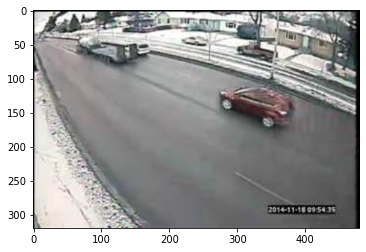

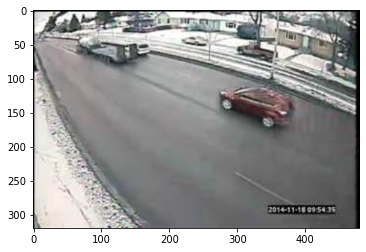

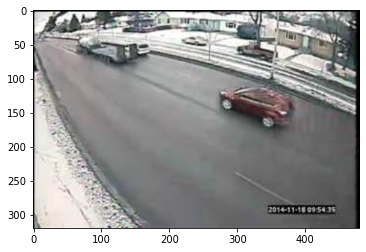

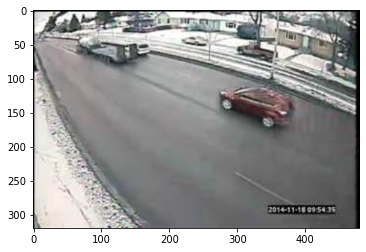

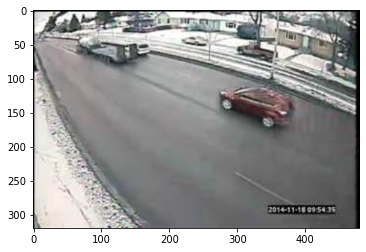

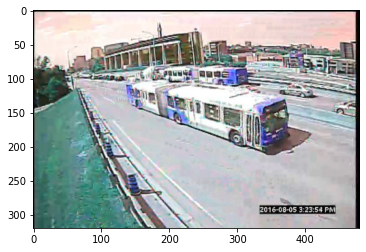

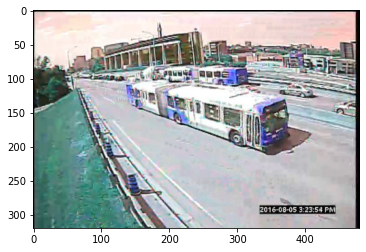

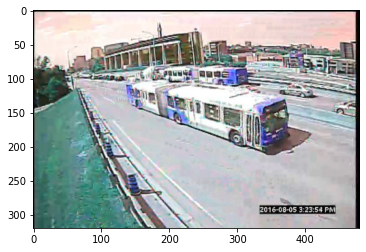

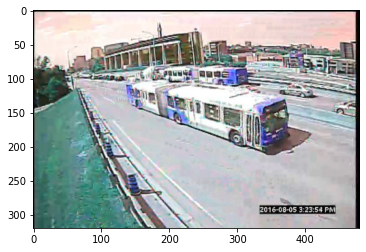

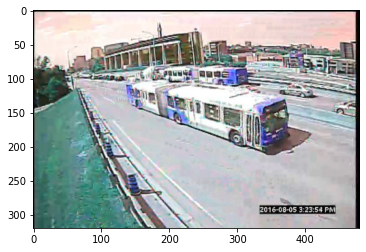

<Figure size 432x288 with 0 Axes>

In [12]:
#NOTE the repeated images due to mulitple ROIs in each image
for k in range(10):
    plt.imshow(images[k])
    plt.figure()


In [13]:
# Analyze the distribution of vehicle types in the limited dataset
vehicle_types = labels_df['class'].value_counts()
print("Distribution of vehicle types:")
print(vehicle_types)

# Address data quality issues arising from the discrepancy between labels and actual image filenames
# Sorting the image filenames
labels_df = labels_df.sort_values('image_id')

Distribution of vehicle types:
car                      682
pickup_truck             111
motorized_vehicle         61
articulated_truck         30
work_van                  29
bus                       28
pedestrian                23
single_unit_truck         18
bicycle                   12
non-motorized_vehicle      5
motorcycle                 1
Name: class, dtype: int64


In [14]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integer labels
label_encoder = LabelEncoder()
classes = label_encoder.fit_transform(classes)


In [15]:
from collections import Counter

# Check class distribution and filter out classes with fewer than 2 samples
class_counts = Counter(classes)
valid_classes = [cls for cls, count in class_counts.items() if count >= 2]

# Filter images, classes, and bounding boxes to retain only valid classes
filtered_indices = [i for i, cls in enumerate(classes) if cls in valid_classes]
images = images[filtered_indices]
classes = classes[filtered_indices]
bounding_boxes = bounding_boxes[filtered_indices]

# Verify if filtering resolved the issue
print(f"Class distribution after filtering: {Counter(classes)}")

# Proceed with stratified split if classes are sufficient
if len(set(classes)) > 1:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in sss.split(images, classes):
        X_train, X_test = images[train_idx], images[test_idx]
        y_train, y_test = classes[train_idx], classes[test_idx]
        bbox_train, bbox_test = bounding_boxes[train_idx], bounding_boxes[test_idx]
else:
    raise ValueError("Not enough classes with sufficient samples for stratified split.")


Class distribution after filtering: Counter({3: 682, 8: 111, 5: 61, 0: 30, 10: 29, 2: 28, 7: 23, 9: 18, 1: 12, 6: 5})


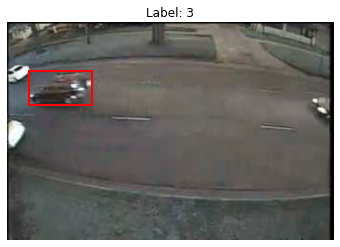

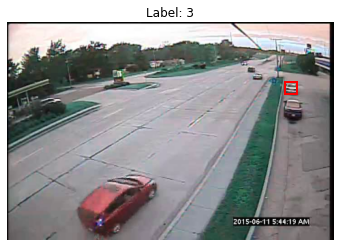

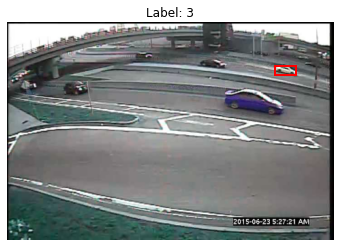

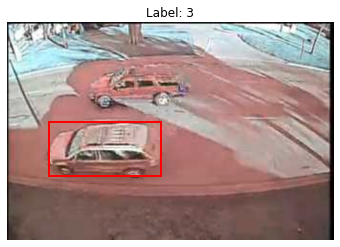

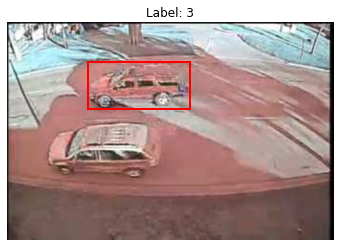

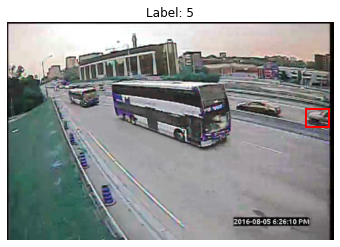

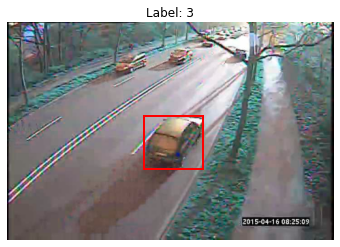

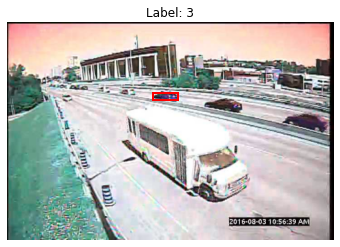

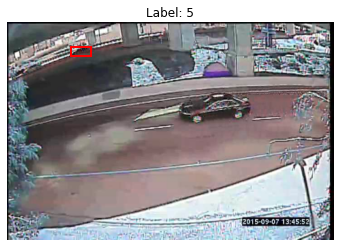

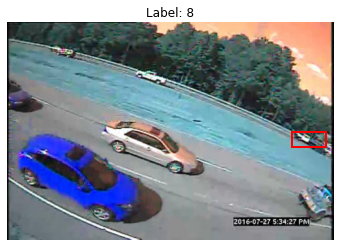

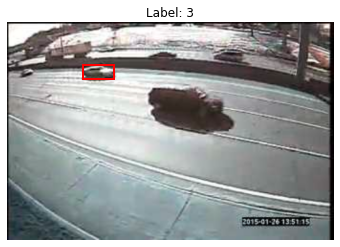

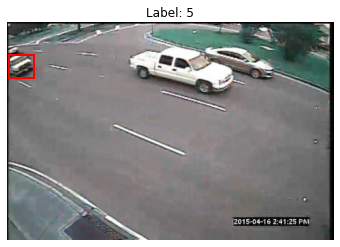

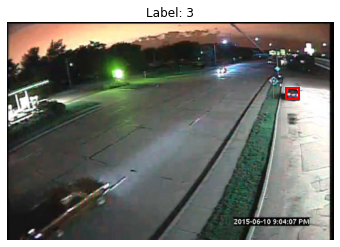

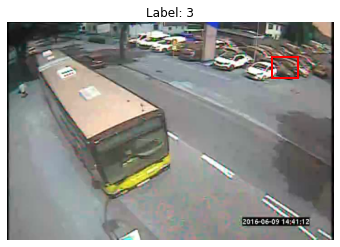

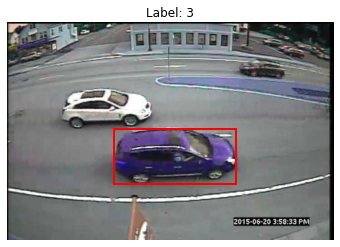

In [16]:
# Sanity check to make sure ROIs align with images in our data

# Function to plot an image with its bounding box
def plot_image_with_bbox(img, bbox, title=None):
    # Rescale the image if needed (assuming the images are in range [0, 255])
    img = img.astype('uint8')  # Ensure the image is in the correct format

    # Plot the image
    plt.imshow(img)
    
    # Unpack bounding box coordinates (x_min, y_min, x_max, y_max)
    x_min, y_min, x_max, y_max = bbox
    
    # Add a rectangle for the bounding box
    plt.gca().add_patch(plt.Rectangle((x_min, y_min),
                                      x_max - x_min,
                                      y_max - y_min, 
                                      fill=False, edgecolor='r', linewidth=2))
    
    if title:
        plt.title(title)
    
    plt.axis('off')  # Turn off the axis
    plt.show()

# Test the plotting with a few samples from X_train and bbox_train
for i in range(15):  # Adjust the range to plot more or fewer images
    img = X_train[i]
    bbox = bbox_train[i]
    label = y_train[i]
    
    # Plot the image with the bounding box
    plot_image_with_bbox(img, bbox, title=f"Label: {label}")


In [18]:
labels = labels_df['class'].to_numpy() # NOTE it is a much better idea here to have a mapping for each class to a label so we can trace these easier
bounding_boxes = labels_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

# scale the bounding boxes based on the changes in image shapes above 
bounding_boxes = bounding_boxes * np.asarray([width, height, width, height])


# Convert labels to one-hot encoding
unique_labels = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for index, label in enumerate(unique_labels)}
labels = np.array([label_to_index[label] for label in labels])

In [19]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    vehicle_class = layers.Dense(num_classes, activation='softmax', name='vehicle_class')(x)
    bounding_box = layers.Dense(4, name='bounding_box')(x)

    # model = keras.Model(inputs=inputs, outputs=[vehicle_class, bounding_box]) #NOTE changed from list to dicitonary to get this to run
    model = keras.Model(inputs=inputs, outputs={'vehicle_class': vehicle_class, 'bounding_box': bounding_box})
    return model

input_shape = images[0].shape
num_classes = len(unique_labels)
model = create_model(input_shape, num_classes)


model.compile(optimizer='adam',
              loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=20, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))

2024-11-15 10:26:11.864998: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - bounding_box_mae: 1669.3362 - loss: 29388092.0000 - vehicle_class_accuracy: 0.0190 - val_bounding_box_mae: 92.3993 - val_loss: 14627.3086 - val_vehicle_class_accuracy: 0.0300
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - bounding_box_mae: 87.0534 - loss: 12415.4902 - vehicle_class_accuracy: 0.0324 - val_bounding_box_mae: 88.1942 - val_loss: 12408.9121 - val_vehicle_class_accuracy: 0.0300
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - bounding_box_mae: 85.0409 - loss: 11850.9258 - vehicle_class_accuracy: 0.0369 - val_bounding_box_mae: 88.3633 - val_loss: 12211.9092 - val_vehicle_class_accuracy: 0.5700
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - bounding_box_mae: 82.2042 - loss: 10870.0195 - vehicle_class_accuracy: 0.5704 - val_bounding_box_mae: 87.7301 - val_loss: 11944.0635 - val_vehicle_class_accuracy: 0.2050
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - bounding_box_mae: 82.2893 - loss: 10767.7324 - veh

#### Evaluate the model and check the test results

In [20]:
# Evaluate model
test_results = model.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
print('\nTest results:', test_results)

7/7 - 9s - 1s/step - bounding_box_mae: 89.1005 - loss: 13506.5430 - vehicle_class_accuracy: 0.4700

Test results: [13506.54296875, 89.10054016113281, 0.4699999988079071]


In [23]:
# Run inference
sample_images = X_test[:5]
predictions = model.predict(sample_images)

# Access predictions by output names
predicted_classes = predictions['vehicle_class']  # Predicted class probabilities
predicted_bounding_boxes = predictions['bounding_box']  # Predicted bounding boxes

print("Predicted classes:", predicted_classes)
print("Predicted bounding boxes:", predicted_bounding_boxes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Predicted classes: [[1.3369879e-04 1.7574942e-23 2.8032517e-33 2.6538655e-01 0.0000000e+00
  2.6798077e-08 2.9416520e-25 7.3447967e-01 6.9098618e-08 1.3610546e-28
  0.0000000e+00]
 [6.6406435e-16 0.0000000e+00 2.9608828e-26 2.6130190e-04 0.0000000e+00
  9.9973863e-01 0.0000000e+00 6.8417786e-23 8.2781144e-37 0.0000000e+00
  0.0000000e+00]
 [5.6325293e-06 2.7427742e-20 1.1594390e-26 8.2232046e-01 0.0000000e+00
  7.3096005e-09 2.6336761e-29 7.0592925e-02 1.0708110e-01 7.4742091e-25
  0.0000000e+00]
 [8.7198452e-12 0.0000000e+00 0.0000000e+00 9.9997342e-01 0.0000000e+00
  8.3826884e-20 1.3201535e-38 2.6605587e-05 2.5709545e-18 8.0698562e-36
  0.0000000e+00]
 [3.7503861e-11 2.2072600e-06 6.9003034e-19 3.3241352e-07 0.0000000e+00
  7.5386009e-10 2.1332128e-14 1.3489783e-05 9.9998403e-01 4.8219302e-12
  1.1068164e-33]]
Predicted bounding boxes: [[325.94046  148.12477  390.0863   141.7273  ]
 [146.64691  107.23606  301.1139    86.76717 ]
 [312.65656  133

#### Run inferences on the images

NameError: name 'predicted_bounding_boxes' is not defined

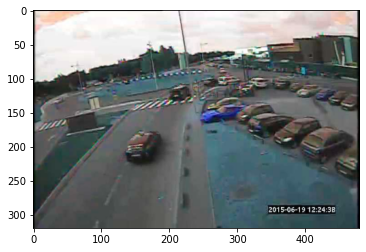

In [22]:
# Visualize predictions
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    plt.gca().add_patch(plt.Rectangle((predicted_bounding_boxes[i][0], predicted_bounding_boxes[i][1]),
                                     predicted_bounding_boxes[i][2] - predicted_bounding_boxes[i][0],
                                     predicted_bounding_boxes[i][3] - predicted_bounding_boxes[i][1],
                                     fill=False, edgecolor='r', linewidth=2))
    plt.show()